In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

# Language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# Language processing with TextBlob
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from collections import Counter

In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
nltk_metrics = spark.read.load('../data/nlp_nltk_metrics_daily.parquet/')

In [6]:
nltk_metrics.show()

+-------------+---------+-------------------+-------------------+-------------------+
|creation_date|msg_count|sum_nltk_negativity|sum_nltk_neutrality|sum_nltk_positivity|
+-------------+---------+-------------------+-------------------+-------------------+
|   2011-04-08|      210| 18.866000071167946|  160.9919998794794| 30.140000104904175|
|   2011-04-09|      207| 17.119000032544136| 155.53500010073185|  34.34400010108948|
|   2011-04-10|      187| 15.378000069409609|  151.7290003299713|  19.89200009033084|
|   2011-04-11|      247| 22.007999943569303| 194.54300020635128|  30.45299991592765|
|   2011-04-12|      252| 23.895000049844384| 195.31200072169304|  32.79300003498793|
|   2011-04-13|      271| 22.283000009134412| 215.56700015813112|  33.15199991129339|
|   2011-04-14|      299| 28.671000043861568| 230.73200015723705|  39.59699996933341|
|   2011-04-15|      247| 23.081999980844557|  195.4639999717474| 28.451999973505735|
|   2011-04-16|      223| 19.808000050485134| 172.8239

In [33]:
nltk_pd = nltk_metrics.toPandas()
nltk_pd = nltk_pd.set_index('creation_date')
nltk_pd = nltk_pd.sort_index()
nltk_pd[:5]

,msg_count,sum_nltk_negativity,sum_nltk_neutrality,sum_nltk_positivity
creation_date,,,,
2005-12-25,1,0.151,0.726,0.123
2006-01-04,1,0.017,0.808,0.176
2006-01-09,1,0.000,1.000,0.000
2006-02-05,1,0.073,0.620,0.307
2006-02-08,2,0.215,1.508,0.277


In [22]:
nltk_metrics.registerTempTable('nltk_metrics')

In [23]:
daily_nltk_metrics = spark.sql("""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nltk_negativity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_negativity_60d_avg,

    AVG(sum_nltk_neutrality) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_neutrality_60d_avg,
    
    AVG(sum_nltk_positivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_positivity_60d_avg

FROM nltk_metrics
""")

In [38]:
nltk_avg = daily_nltk_metrics.toPandas()
nltk_avg = nltk_avg.set_index('creation_date')
nltk_avg = nltk_avg.sort_index()
nltk_avg[:5]

,msg_count_60d_avg,nltk_negativity_60d_avg,nltk_neutrality_60d_avg,nltk_positivity_60d_avg
creation_date,,,,
2005-12-25,1.0,0.0560,0.844667,0.099667
2006-01-04,1.0,0.0560,0.844667,0.099667
2006-01-09,1.2,0.0912,0.932400,0.176600
2006-02-05,1.1,0.0556,0.913400,0.131000
2006-02-08,1.1,0.0556,0.913400,0.131000


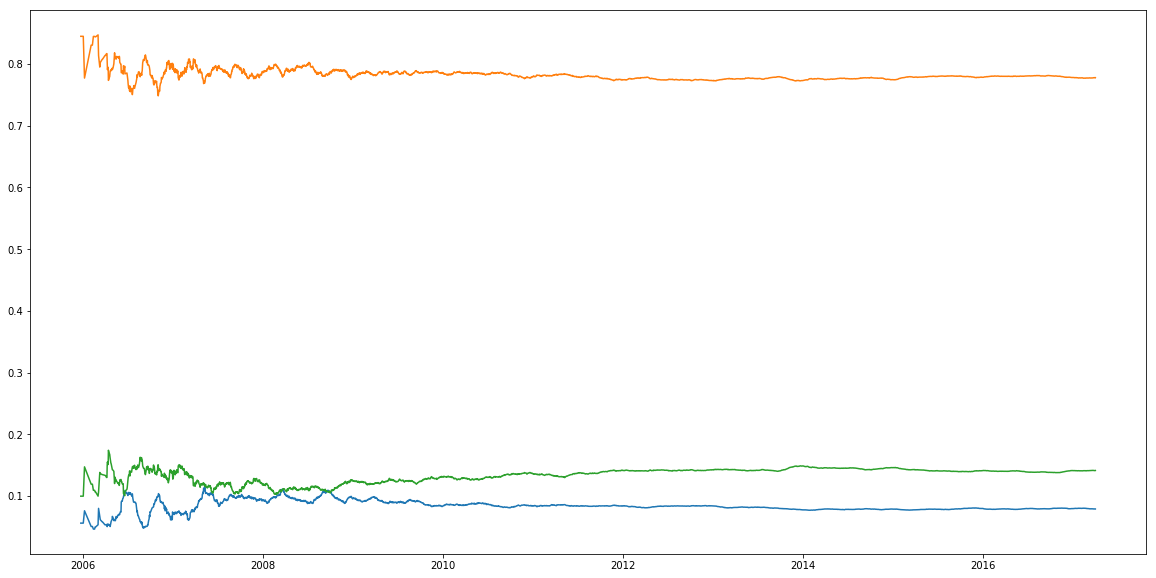

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(nltk_avg['nltk_negativity_60d_avg']/nltk_avg['msg_count_60d_avg'])
plt.plot(nltk_avg['nltk_neutrality_60d_avg']/nltk_avg['msg_count_60d_avg'])
plt.plot(nltk_avg['nltk_positivity_60d_avg']/nltk_avg['msg_count_60d_avg'])

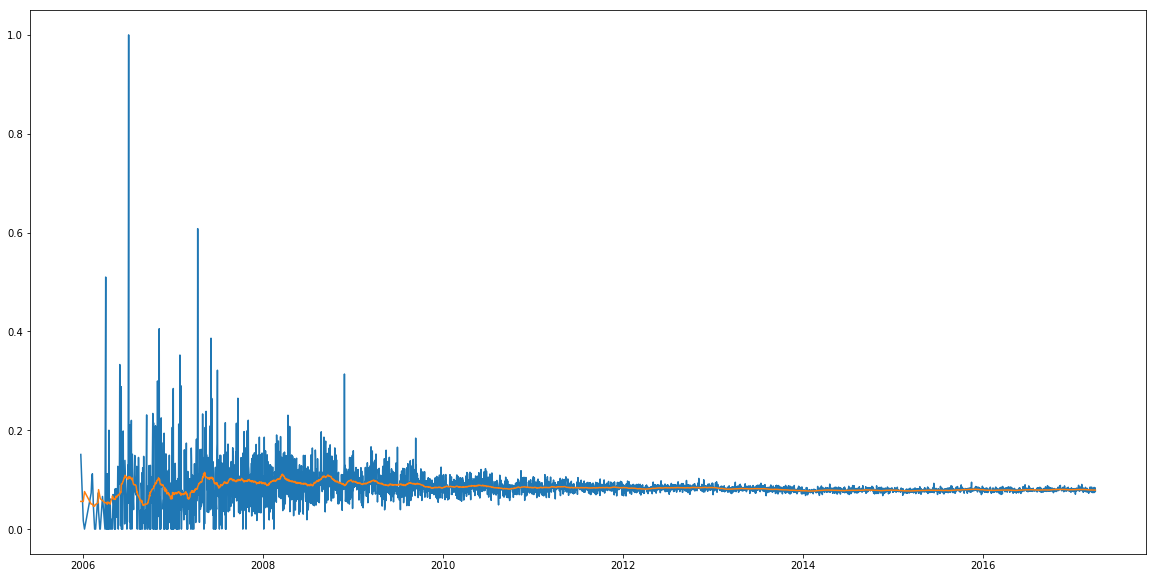

In [46]:
plt.figure(figsize=(20, 10))
plt.plot(nltk_pd['sum_nltk_negativity']/nltk_pd['msg_count'])
plt.plot(nltk_avg['nltk_negativity_60d_avg']/nltk_avg['msg_count_60d_avg'])

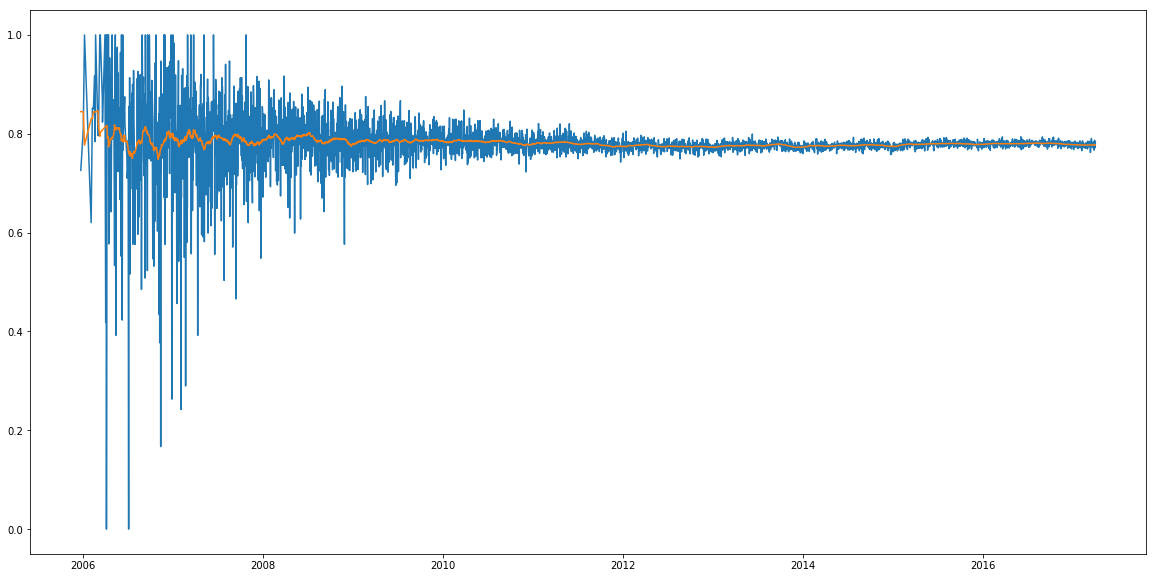

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(nltk_pd['sum_nltk_neutrality']/nltk_pd['msg_count'])
plt.plot(nltk_avg['nltk_neutrality_60d_avg']/nltk_avg['msg_count_60d_avg'])

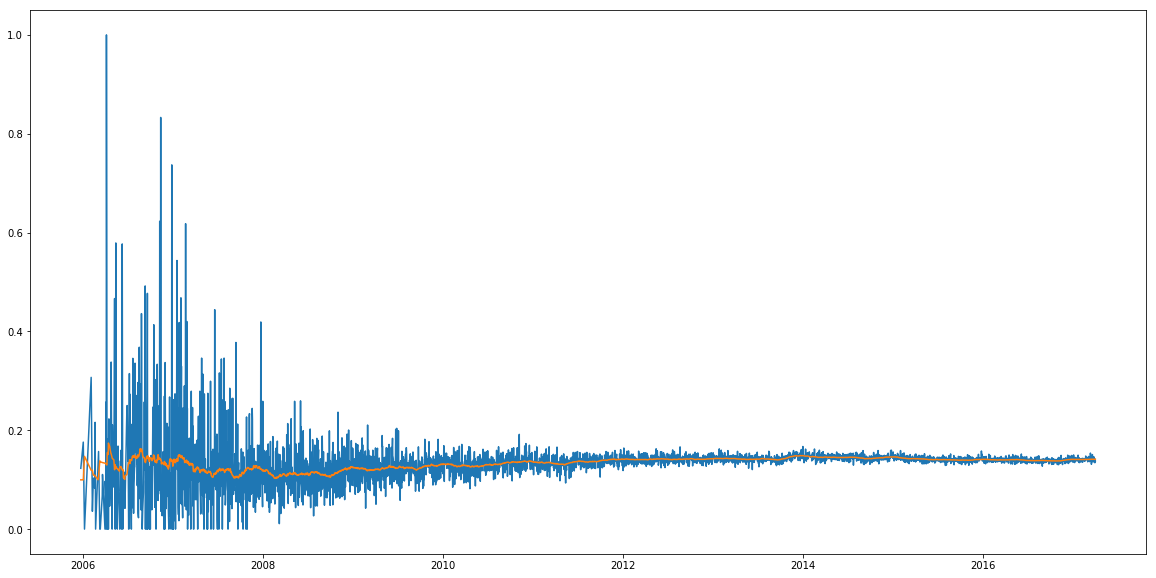

In [48]:
plt.figure(figsize=(20, 10))
plt.plot(nltk_pd['sum_nltk_positivity']/nltk_pd['msg_count'])
plt.plot(nltk_avg['nltk_positivity_60d_avg']/nltk_avg['msg_count_60d_avg'])

# Average over first 8 day of January 2017

In [3]:
nlp_metrics = spark.read.load('../data/daily_2017_01_nlp_metrics.parquet/')

In [20]:
rows = nlp_metrics.collect()
row = rows[0]
row

Row(creation_date=datetime.date(2017, 1, 1), nltk_negativity_60d_avg=180013.25666697026, nltk_neutrality_60d_avg=1776462.7587395571, nltk_positivity_60d_avg=324456.70514096733, text_blob_polarity_60d_avg=20857.047301106853, text_blob_subjectivity_60d_avg=83736.125, nb_bw_matches_60d_avg=217541.375, nb_hw_matches_60d_avg=39619.375, hw_ref_intensity_60d_avg=3832.16623198241, nb_hw_ref_matches_60d_avg=6217.75)

In [24]:
nltk_neg_8_avg = row[1]
nltk_neu_8_avg = row[2]
nltk_pos_8_avg = row[3]
nltk_total = row[1] + row[2] + row[3]
blob_pol_8_avg = row[4]
blob_subj_8_avg = row[5]
bw_matches_8_avg = row[6]
hw_matches_8_avg = row[7]
hw_ref_matches_8_avg = row[8]

In [23]:
print('Over 8 day, the average negativity is {}, neutrality is {}, positivity is {}'.format(row[1], row[2], row[3]))

Over 8 day, the average negativity is 180013.25666697026, neutrality is 1776462.7587395571, positivity is 324456.70514096733


In [25]:
print('Over 8 day, the proportion of negativity is {}, neutrality is {}, positivity is {}'.format(row[1]/nltk_total, row[2]/nltk_total, row[3]/nltk_total))

Over 8 day, the proportion of negativity is 0.07892089715989585, neutrality is 0.778831722100576, positivity is 0.1422473807395282


Therefore, we notice that positivity in posts is two times more present that negativity.

# First 5 days of January 2017

In [26]:
nlp_metrics_full = spark.read.load('../data/daily_nlp_metrics_full.parquet/')

In [27]:
nlp_metrics_full.show()

+-------+-------------+--------------------+---------------+---------------+---------------+------------------+----------------------+-------------+-------------+----------------+-----------------+
|     id|creation_date|                body|nltk_negativity|nltk_neutrality|nltk_positivity|text_blob_polarity|text_blob_subjectivity|nb_bw_matches|nb_hw_matches|hw_ref_intensity|nb_hw_ref_matches|
+-------+-------------+--------------------+---------------+---------------+---------------+------------------+----------------------+-------------+-------------+----------------+-----------------+
|dby6jwk|   2017-01-03|GoW 4 was release...|            0.0|            1.0|            0.0|               0.0|                   0.0|          0.0|          0.0|             0.0|              0.0|
|dby6jwl|   2017-01-03|Firmino really do...|            0.0|            1.0|            0.0|               0.0|                   0.0|          0.0|          0.0|             0.0|              0.0|
|dby6jwm| 

In [37]:
nlp_per_day = nlp_metrics_full.withColumn('dummy', func.lit(1)).groupBy('creation_date').sum()

In [40]:
pd_per_day = nlp_per_day.toPandas()

In [41]:
pd_per_day

,creation_date,sum(nltk_negativity),sum(nltk_neutrality),sum(nltk_positivity),sum(text_blob_polarity),sum(text_blob_subjectivity),sum(nb_bw_matches),sum(nb_hw_matches),sum(hw_ref_intensity),sum(nb_hw_ref_matches),sum(dummy)
0,2017-01-04,188601.709181,1.917216e+06,344668.157413,22675.253298,91393.0,228173.0,42919.0,3488.480983,5625.0,2454012
1,2017-01-05,199845.992185,1.950554e+06,349086.348415,23150.745999,92283.0,243531.0,45370.0,6396.886955,10575.0,2503011
2,2017-01-01,152172.005136,1.448465e+06,276893.661343,16782.196386,67774.0,177666.0,30003.0,2423.016994,3938.0,1881201
3,2017-01-02,169650.015161,1.680213e+06,308789.881374,19915.737242,79217.0,204315.0,37675.0,3248.180991,5217.0,2162208
4,2017-01-03,186446.544172,1.887507e+06,342307.846394,21948.237553,89255.0,223111.0,41885.0,3765.949985,5986.0,2419728


In [51]:
pd_per_day.dtypes

creation_date                   object
sum(nltk_negativity)           float64
sum(nltk_neutrality)           float64
sum(nltk_positivity)           float64
sum(text_blob_polarity)        float64
sum(text_blob_subjectivity)    float64
sum(nb_bw_matches)             float64
sum(nb_hw_matches)             float64
sum(hw_ref_intensity)          float64
sum(nb_hw_ref_matches)         float64
sum(dummy)                       int64
dtype: object

In [52]:
pd_percentage = pd_per_day.iloc[:, 1:-1].div(pd_per_day.iloc[:, -1], axis=0)

In [53]:
pd_percentage

,sum(nltk_negativity),sum(nltk_neutrality),sum(nltk_positivity),sum(text_blob_polarity),sum(text_blob_subjectivity),sum(nb_bw_matches),sum(nb_hw_matches),sum(hw_ref_intensity),sum(nb_hw_ref_matches)
0,0.076854,0.781258,0.140451,0.009240,0.037242,0.092980,0.017489,0.001422,0.002292
1,0.079842,0.779283,0.139467,0.009249,0.036869,0.097295,0.018126,0.002556,0.004225
2,0.080891,0.769968,0.147190,0.008921,0.036027,0.094443,0.015949,0.001288,0.002093
3,0.078461,0.777082,0.142812,0.009211,0.036637,0.094494,0.017424,0.001502,0.002413
4,0.077053,0.780049,0.141465,0.009071,0.036886,0.092205,0.017310,0.001556,0.002474
